### Import stuff

In [20]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

### Get the data

In [21]:
# Load dataset directories
no_tumor_dir = 'data/no'
yes_tumor_dir = 'data/yes'

In [22]:
# Function to load images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
    return images

In [23]:
# Load images
no_tumor_images = load_images_from_folder(no_tumor_dir)
yes_tumor_images = load_images_from_folder(yes_tumor_dir)

In [24]:
# Create labels
no_tumor_labels = [0] * len(no_tumor_images)
yes_tumor_labels = [1] * len(yes_tumor_images)

In [25]:
# Combine data and labels
X = np.array(no_tumor_images + yes_tumor_images)
y = np.array(no_tumor_labels + yes_tumor_labels)

### Normalize and some other stuff

In [26]:
# Data Preprocessing
X = X / 255.0
y = to_categorical(y, num_classes=2)

In [27]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# this performs some random transformations on the images to create new slightly altered versions
# creates a diverse set of training examples to help improve the model

In [29]:
# Use Transfer Learning (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

In [36]:
# Add custom layers
input_layer = Input(shape=(128, 128, 3))
x = base_model(input_layer, training=False) # training=False makes it run in inference mode
x = Flatten()(x) # flattened from 3d to 1d
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(2, activation='softmax')(x) # 2 categories: tumor and no tumor

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Model training
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=25, validation_data=(X_test, y_test))

Epoch 1/25


C:\Users\rkbid\anaconda3\envs\MRI\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 947ms/step - accuracy: 0.5437 - loss: 1.9357 - val_accuracy: 0.5098 - val_loss: 0.6736
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5059 - loss: 0.9840 - val_accuracy: 0.6078 - val_loss: 0.8336
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6595 - loss: 0.8169 - val_accuracy: 0.5294 - val_loss: 0.6746
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5867 - loss: 0.7809 - val_accuracy: 0.8431 - val_loss: 0.4123
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7269 - loss: 0.5083 - val_accuracy: 0.8824 - val_loss: 0.3920
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8278 - loss: 0.4606 - val_accuracy: 0.8824 - val_loss: 0.3860
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7315 - loss: 0.5208 - val_accuracy: 0.8431 - val_loss: 0.3965
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7966 - loss: 0.4726 - val_accuracy: 0.9020 - val_loss: 0.3722
Epoch 9/25
7/7 ━━━━━━━━━

In [38]:
# Model evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 715ms/step


In [39]:
# Classification report and confusion matrix
print("Classification Report:\n", classification_report(y_true, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.75      0.83        20
           1       0.86      0.97      0.91        31

    accuracy                           0.88        51
   macro avg       0.90      0.86      0.87        51
weighted avg       0.89      0.88      0.88        51

Confusion Matrix:
 [[15  5]
 [ 1 30]]


### Visualization

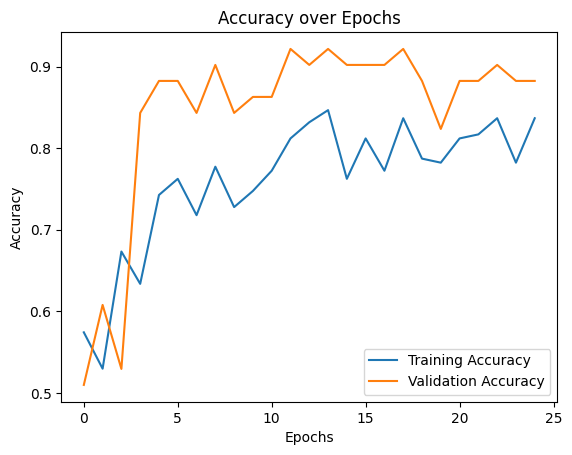

In [40]:
# Plotting training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.savefig('accuracy_plot.png')
plt.show()

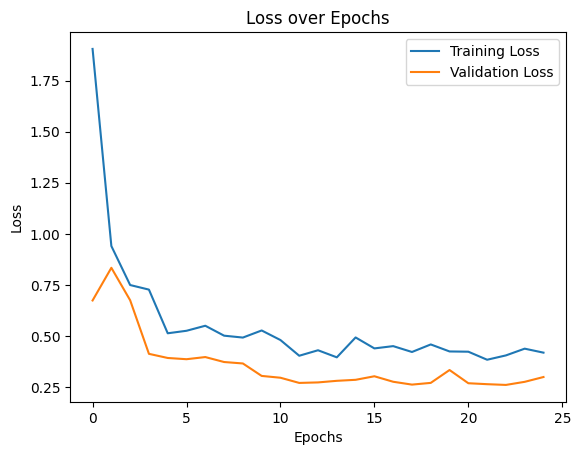

In [41]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('loss_plot.png')
plt.show()

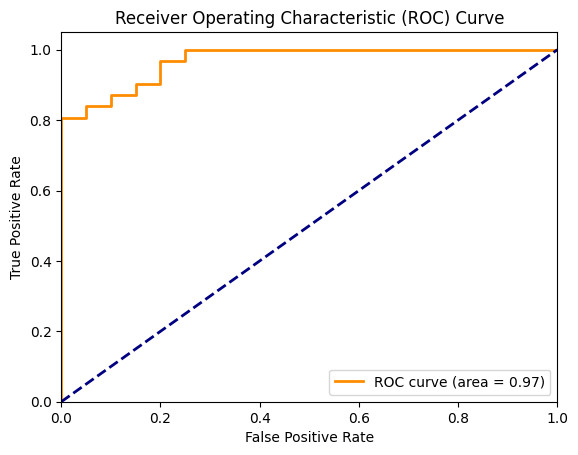

In [42]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_diagram.png')
plt.show()

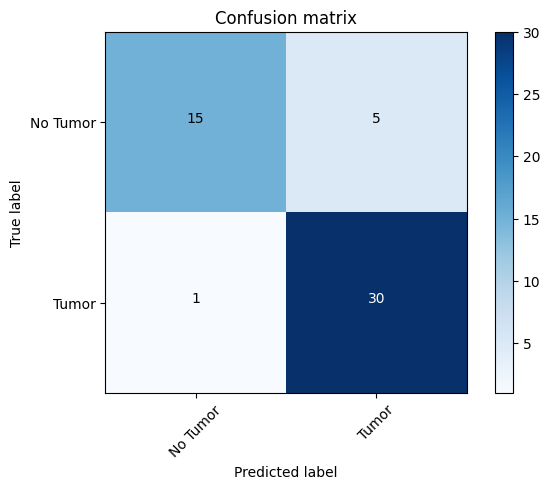

In [43]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm.png')
cm = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(cm, classes=['No Tumor', 'Tumor'])

In [44]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,008,456 (80.14 MB)

 Trainable params: 2,097,922 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 4,195,846 (16.01 MB)

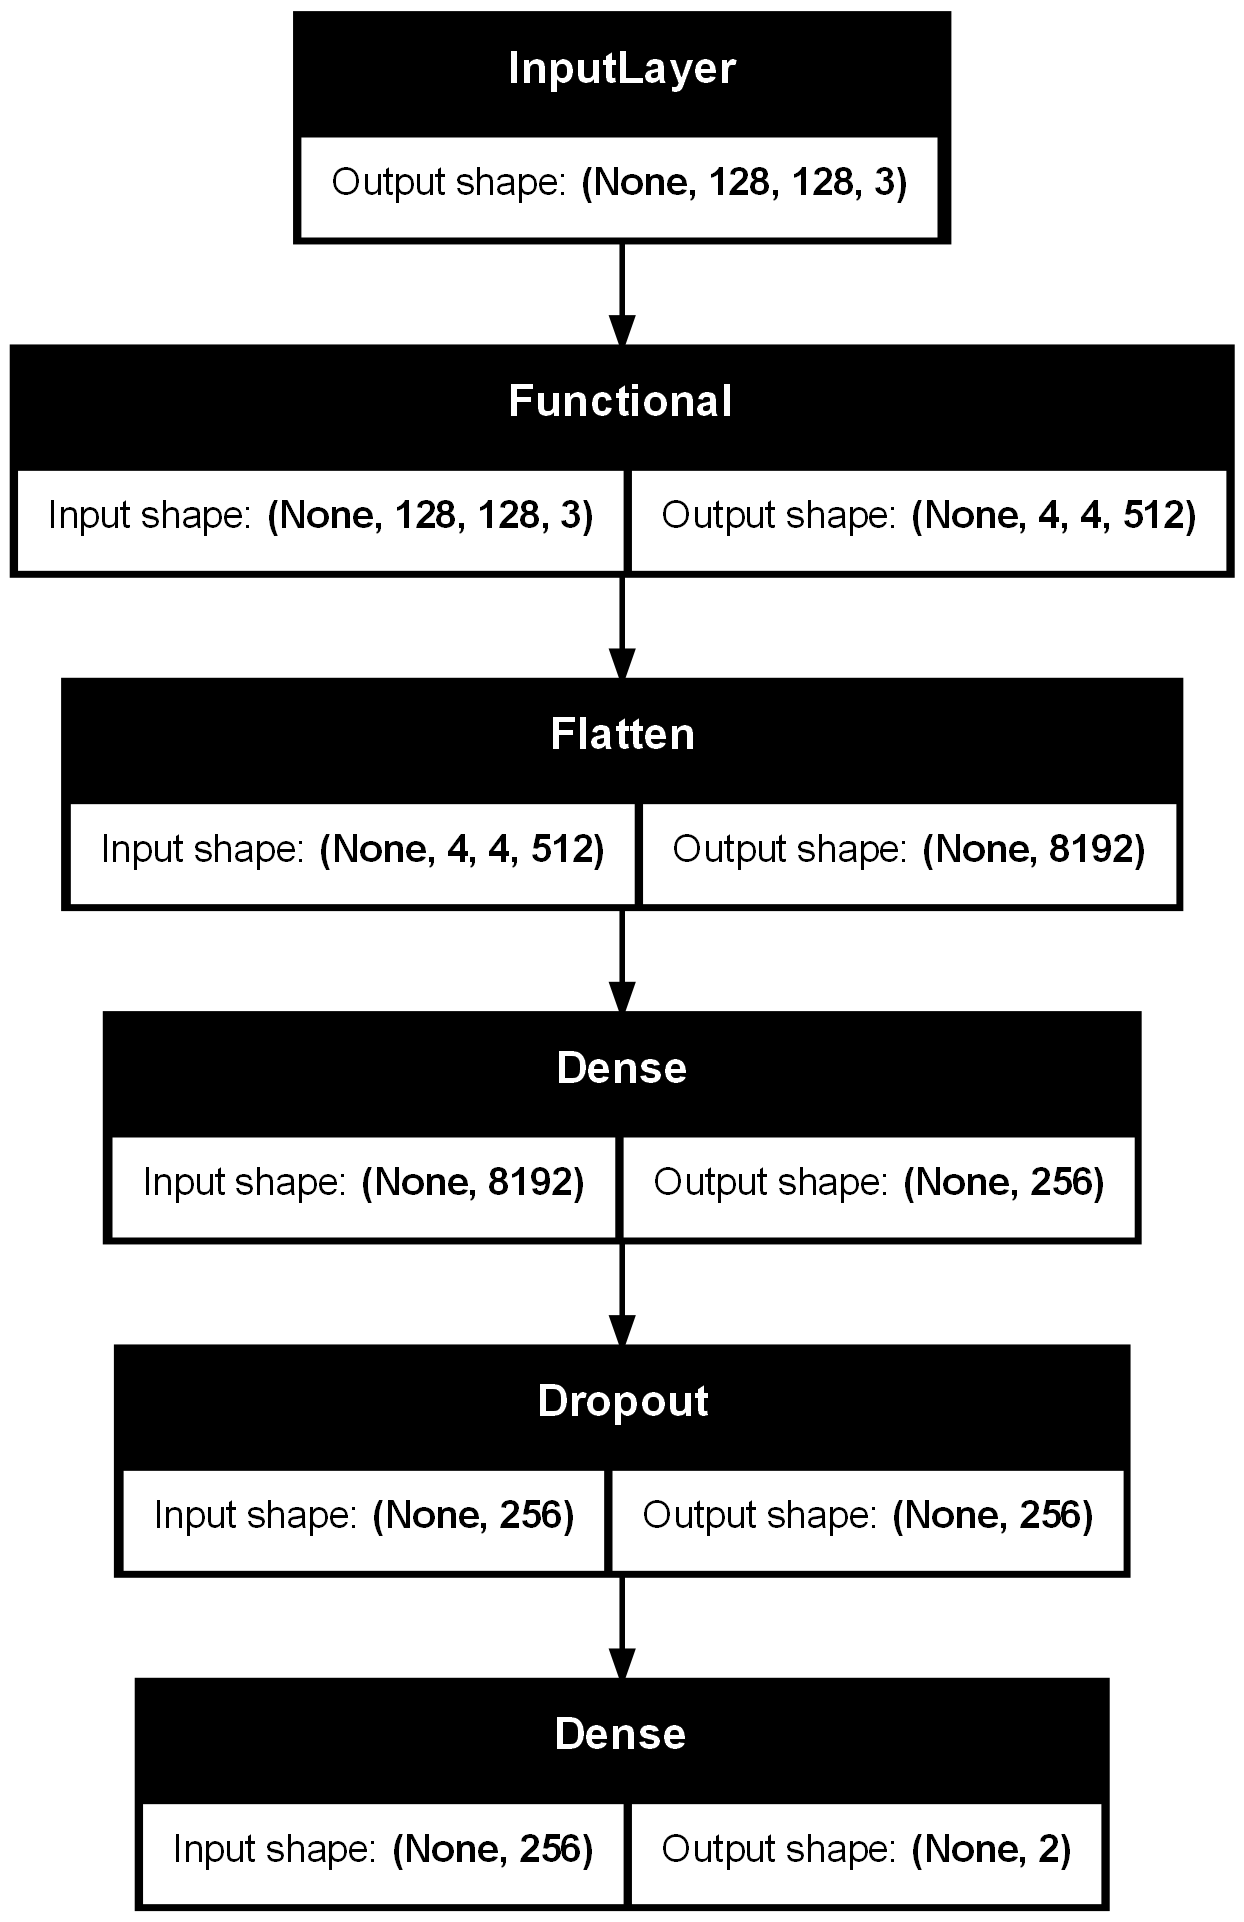

In [45]:
plot_model(model, to_file='tf_model.png', show_shapes=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Visualizing activations for layer: block1_conv1


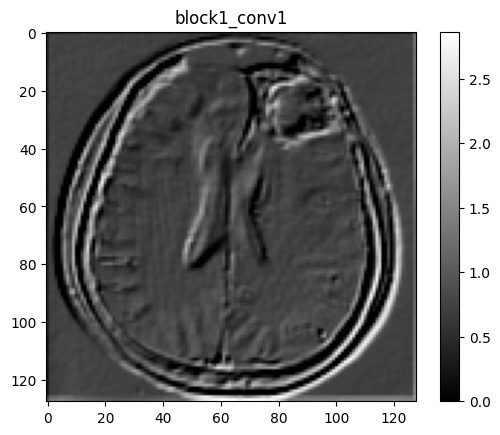

Visualizing activations for layer: block1_conv2


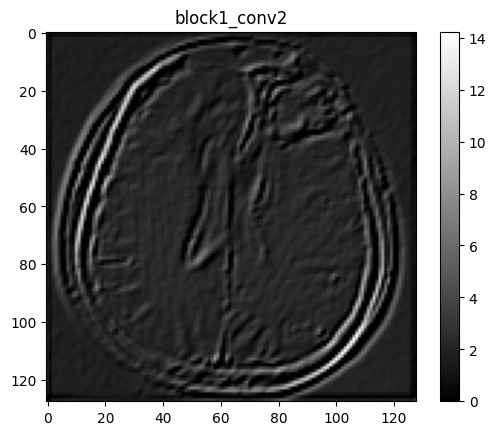

Visualizing activations for layer: block1_pool


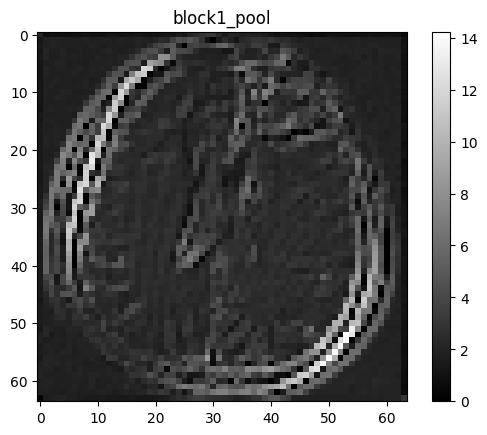

Visualizing activations for layer: block2_conv1


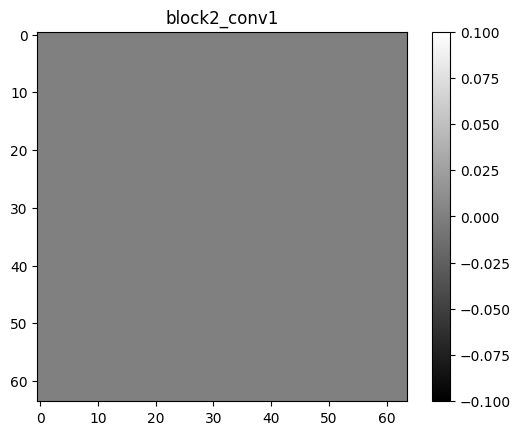

Visualizing activations for layer: block2_conv2


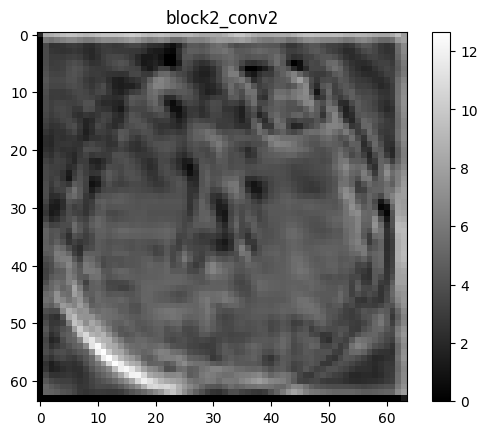

Visualizing activations for layer: block2_pool


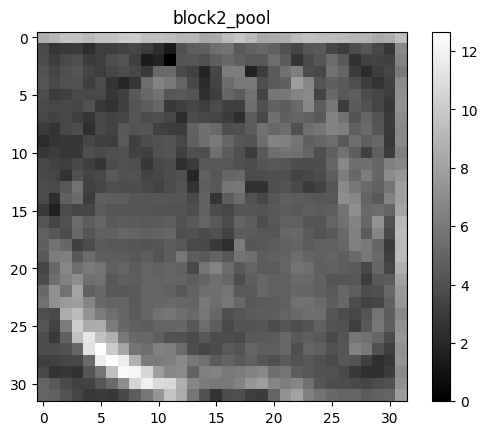

Visualizing activations for layer: block3_conv1


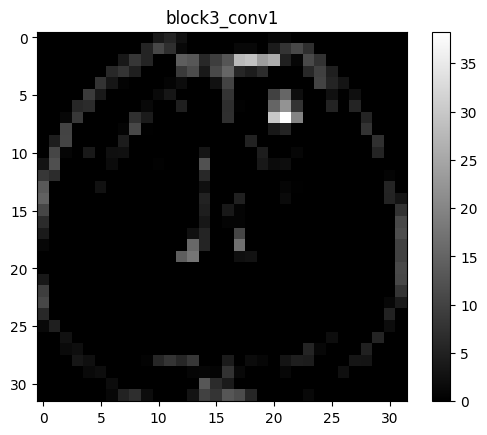

Visualizing activations for layer: block3_conv2


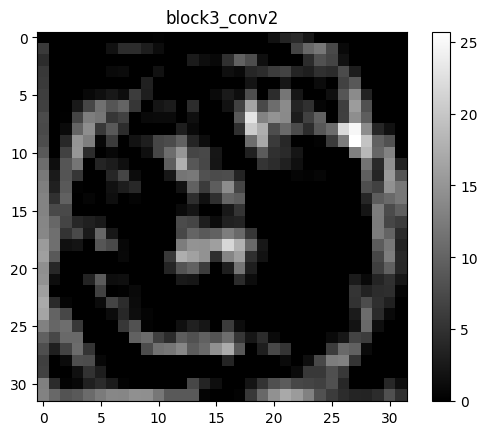

Visualizing activations for layer: block3_conv3


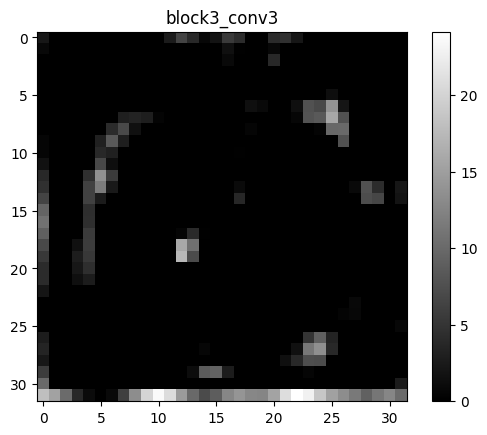

Visualizing activations for layer: block3_pool


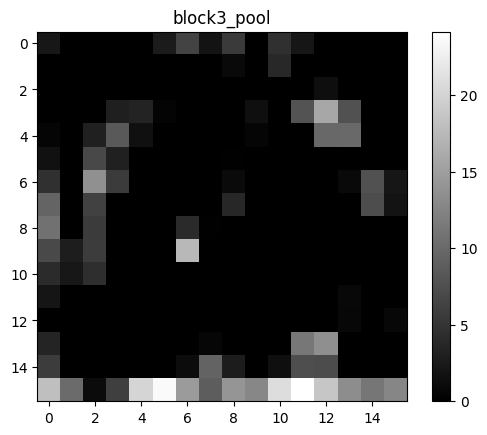

Visualizing activations for layer: block4_conv1


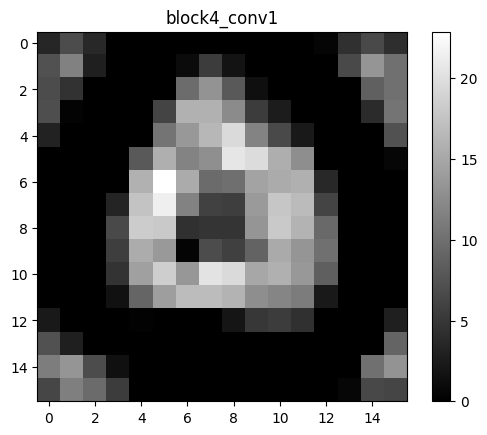

Visualizing activations for layer: block4_conv2


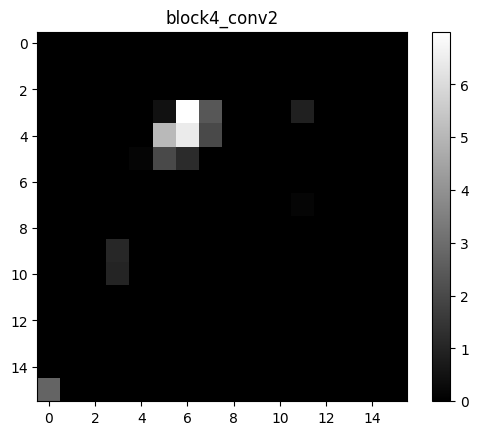

Visualizing activations for layer: block4_conv3


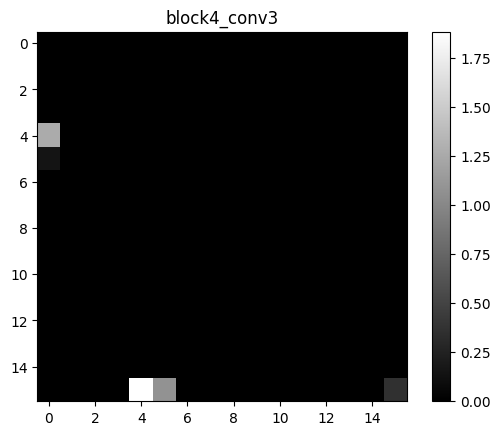

Visualizing activations for layer: block4_pool


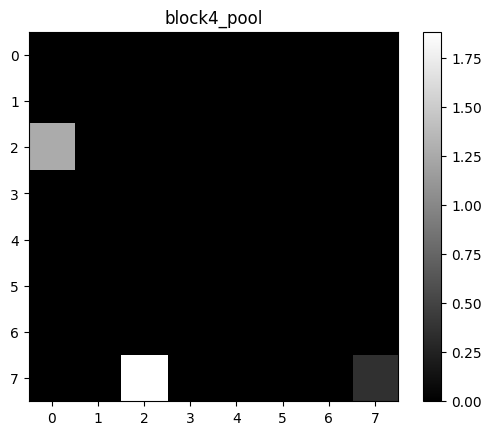

Visualizing activations for layer: block5_conv1


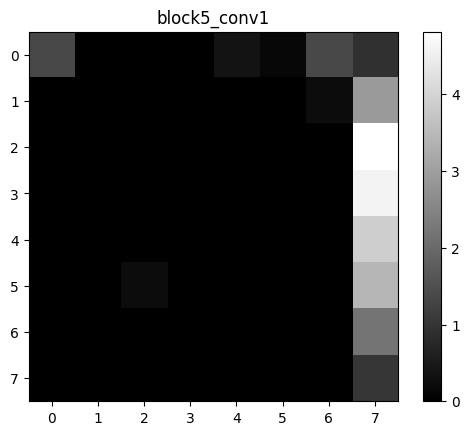

Visualizing activations for layer: block5_conv2


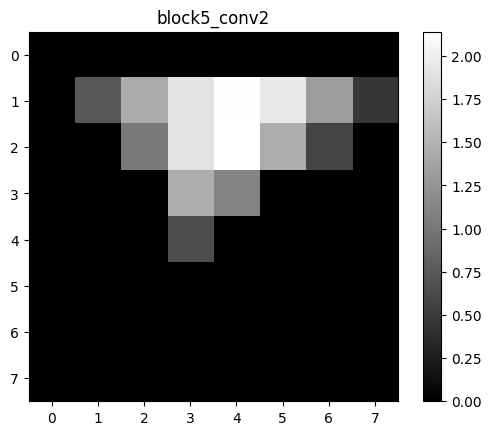

Visualizing activations for layer: block5_conv3


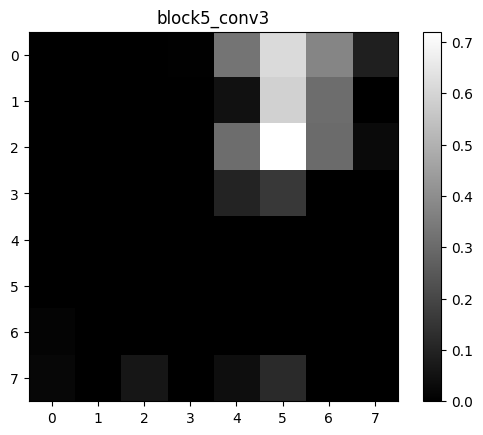

Visualizing activations for layer: block5_pool


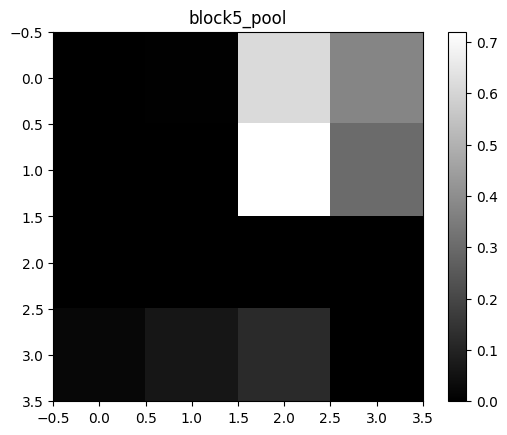

In [57]:
import os

# Create directory to save activation images
os.makedirs('activation_images', exist_ok=True)

# Visualize activations for each layer
from tensorflow.keras import models

# Extract the convolutional and pooling layers
layer_outputs = [layer.output for layer in base_model.layers if 'conv' in layer.name or 'pool' in layer.name]

# Create a model to output the activations
activation_model = models.Model(inputs=base_model.input, outputs=layer_outputs)

# Use a sample image from the test set
sample_image = X_test[:1]

# Get the activations
activations = activation_model.predict(sample_image)

# Function to plot the activations
def display_activation(activations, layer_index):
    activation = activations[layer_index]
    # Plot the first channel for simplicity in grayscale
    plt.imshow(activation[0, :, :, 0], cmap='gray')
    plt.title(base_model.layers[layer_index + 1].name)  # +1 to align with base_model layers
    plt.colorbar()
    plt.savefig(f'activation_images/{base_model.layers[layer_index + 1].name}.png')
    plt.show()

# Visualize and save activations for each layer
for i, layer_activation in enumerate(activations):
    print(f"Visualizing activations for layer: {base_model.layers[i + 1].name}")  # +1 to align with base_model layers
    display_activation(activations, i)


In [55]:
len(activations)

18